some links to sparse methods in NumPy: 

https://github.com/scipy/scipy/issues/3343
https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.eliminate_zeros.html
https://github.com/scipy/scipy/issues/7531


#### Time-triggered algorithm -- proof of concept with different models

In [1]:
%display typeset

In [2]:
from carlin.polynomial_ode import PolynomialODE

# ========================
# Lotka-Volterra model
# ========================
x = polygens(QQ, ['x0', 'x1'])

In [3]:
# parameters from Nikos
alpha=2
beta=1
delta=1;
gamma=0.25;

In [4]:
# parameters from A. Rocca (cf. wikipedia)
# [0.9, 1.1] x [0.9, 1.1]
# T = 16 for one loop
alpha=2./3  # 2;
beta=4/3.  #1;
delta=1
gamma=1. # 0.25;

In [5]:
# parameters from the thesis of M. A. Ben Sassi
# [49, 51] x [14, 16]
# T = 0.3*700
alpha=0.1
beta=0.01
delta=0.001
gamma=0.05

In [3]:
# parameters from Aachen
# [4.8, 5.2] x [1.8, 2.2]
# T = 5
alpha=1.5
beta=1.0
gamma=3.0
delta=1.0

In [4]:
# equation
f = [alpha*x[0] - beta*x[0]*x[1], delta*x[0]*x[1]-gamma*x[1]]
model = PolynomialODE(f, 2, 2)
f

[-x0*x1 + 1.50000000000000*x0, x0*x1 - 3.00000000000000*x1]

In [51]:
# Truncation
from carlin.transformation import truncated_matrix, get_Fj_from_model

Fj = get_Fj_from_model(model.funcs(), model.dim(), model.degree())
AN = lambda N : truncated_matrix(N, *Fj, input_format="Fj_matrices")
AN3 = AN(3)

In [48]:
from scipy.sparse import csr_matrix

csr_matrix.eliminate_zeros(AN(3))

TypeError: unbound method eliminate_zeros() must be called with csr_matrix instance as first argument (got coo_matrix instance instead)

In [74]:
AN3.eliminate_zeros()

AttributeError: eliminate_zeros not found

In [80]:
AN3csr = AN3.tocsr(); type(AN3csr)

<class 'scipy.sparse.csr.csr_matrix'>

In [81]:
AN3csr.eliminate_zeros(); AN3csr

<14x14 sparse matrix of type '<type 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

In [66]:
AN3csr = AN3.tocsr()''

<14x14 sparse matrix of type '<type 'numpy.float64'>'
	with 44 stored elements in Compressed Sparse Row format>

In [72]:
csr_matrix.eliminate_zeros(AN3csr)

TypeError: unbound method eliminate_zeros() must be called with csr_matrix instance as first argument (got NoneType instance instead)

In [27]:
AN = matrix(AN(3).toarray())

In [12]:
from carlin.io import solve_ode_exp

# initial time
tini = 0
    
# final time
T = 5.

# initial condition
x0 = [5., 2.]

# fixed number of resets
NRESETS = 300

# number of computation points in total
NPOINTS = 1500

tdom = srange(tini, T, (T-tini)/(NPOINTS-1)*1., include_endpoint=True)

# number of samples in each chunk
CHUNK_SIZE = int(NPOINTS/(NRESETS+1))

# variable that we plot x1 -> 0 and x2 -> 1
j = 1

# number of dimensions of AN
#AN(2).shape[0]

In [13]:
#=========================
# Time-triggered Algorithm
#=========================

# new plot?
G = Graphics()

# truncation order and color
#N = 2; color="blue"
N = 3; color="violet"
#N = 4; color="orange"
#N = 8; color="red"

sol_tot = []
tdom_k = tdom[0:CHUNK_SIZE]
x0_k = x0
sol_chunk_k = solve_ode_exp(AN(N), x0=x0_k, N=N, tini=tdom_k[0], T=tdom_k[-1], NPOINTS=CHUNK_SIZE)
G += list_plot(zip(tdom_k, sol_chunk_k[:, j]), plotjoined=True, 
               linestyle="dashed", color=color, legend_label="$N="+str(N)+", r="+str(NRESETS)+"$")
sol_tot.append(sol_chunk_k[:, 0:2])

for i in range(1, NRESETS+1):
    tdom_k = tdom[CHUNK_SIZE*(i)-1:CHUNK_SIZE*(i+1)]
    x0_k = list(sol_chunk_k[-1, 0:2])
    sol_chunk_k = solve_ode_exp(AN(N), x0=x0_k, N=N, tini=0, T=tdom_k[-1]-tdom_k[0], NPOINTS=CHUNK_SIZE+1)
    sol_tot.append(sol_chunk_k[:, 0:2])
    
    # add point at switching time?
    G += point([tdom_k[0], x0_k[1]], size=25, marker='x', color=color)
    
    # add solution for this chunk
    G += list_plot(zip(tdom_k, sol_chunk_k[:, j]), plotjoined=True, linestyle="dashed", color=color)

In [14]:
# solution of the nonlinear ODE
S = model.solve(x0=x0, tini=tini, T=T, NPOINTS=NPOINTS)
x_t = lambda i : S.interpolate_solution(i)
G += plot(x_t(j), tini, T, axes_labels = ["$t$", "$x_2$"], gridlines=True, color="black")

/Users/forets/Tools/sage-master/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


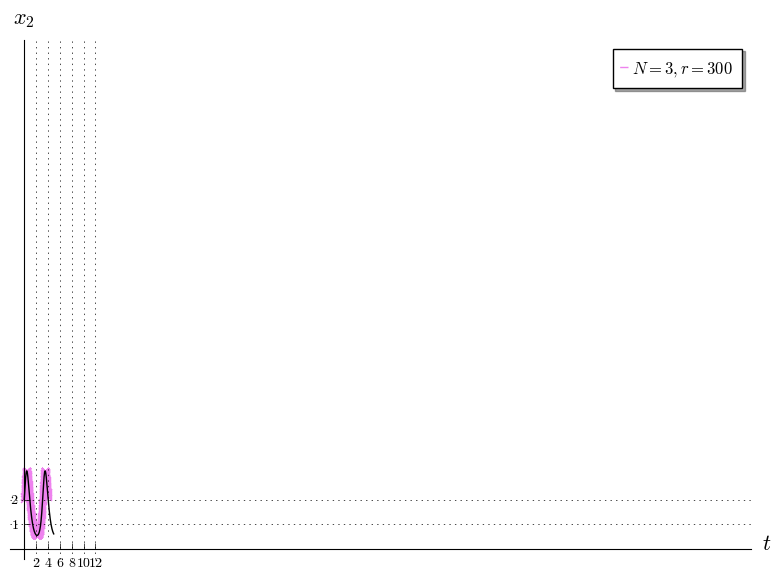

In [15]:
#xmin=0; xmax=25; ymin=-2.2; ymax=10
xmin=0; xmax=120; ymin=0; ymax=20
G.show(gridlines=True, axes_labels = ["$t$", "$x_2$"], 
                 xmin=xmin, xmax=xmax, ymin=ymin,ymax=ymax,
                tick_formatter=[["$0$","$2$", "$4$", "$6$", "$8$", "$10$", "$12$"], 
                             ["$-2$","$-1$", "$0$", "$1$", "$2$"]],
                ticks=[[0, 2, 4, 6, 8, 10, 12], 
                   [-2, -1, 0, 1, 2]],
                legend_loc="upper right")

In [78]:
### save file
xmin=0; xmax=12; ymin=-2.2; ymax=2.2
G.save("timetrigg_vdp_g4.png", gridlines=True, axes_labels = ["$t$", "$x_2$"], 
                 xmin=xmin, xmax=xmax, ymin=ymin,ymax=ymax,
                tick_formatter=[["$0$","$2$", "$4$", "$6$", "$8$", "$10$", "$12$"], 
                             ["$-2$","$-1$", "$0$", "$1$", "$2$"]],
                ticks=[[0, 2, 4, 6, 8, 10, 12], 
                   [-2, -1, 0, 1, 2]],
                legend_loc="upper right")

#### Plots in state space

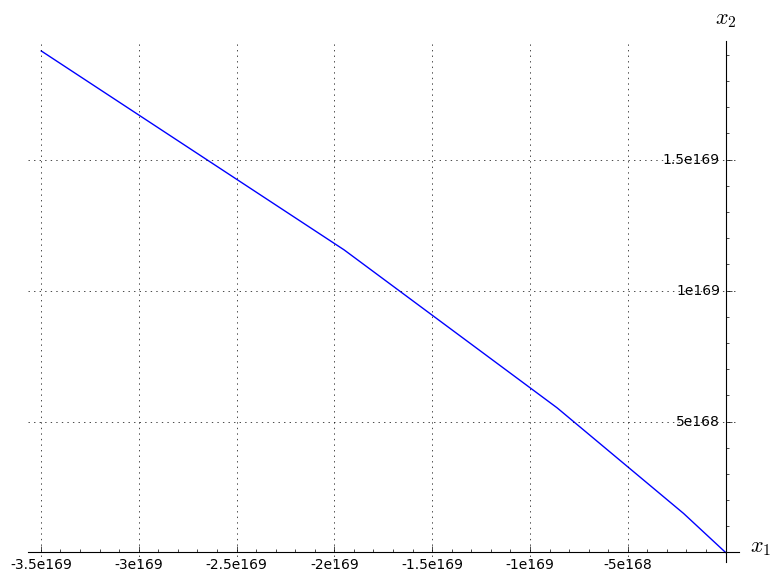

In [229]:
Gss = Graphics()

# add plot by time-triggered
Gss += sum([list_plot(sol_chunk_k, 
               plotjoined=True, linestyle="solid", gridlines=True, 
               axes_labels = ['$x_1$', '$x_2$']) 
     for sol_chunk_k in sol_tot])

# add plot by numerical sol
sol_x1 = [x_t(0)[i][1] for i in range(len(x_t(0)))]
sol_x2 = [x_t(1)[i][1] for i in range(len(x_t(1)))]
Gss += list_plot(zip(sol_x1, sol_x2), plotjoined=True, color="black")

Gss.show()

## Export model to MAT

In [16]:
from carlin.io import export_model_to_mat

#export_model_to_mat('LV.mat', F=Fj, n=2, k=2)

from carlin.transformation import linearize

In [17]:
linearize(model, 'LV_Aachen_N_3.mat', 3, x0)

Obtaining the canonical representation... done
Computing matrix BN... done
Computing the quadratic reduction... done
Computing the characteristics of the model... done
Exporting to  LV_Aachen_N_3.mat ... done


In [18]:
from polyhedron_tools.misc import BoxInfty
X0 = BoxInfty(lengths=[[4.8, 5.2], [1.8, 2.2]])

In [19]:
linearize(model, 'LV_Aachen_N_3.mat', 3, X0)

Obtaining the canonical representation... done
Computing matrix BN... done
Computing the quadratic reduction... done
Computing the characteristics of the model... done
Exporting to  LV_Aachen_N_3.mat ... done


In [20]:
cp LV_Aachen_N_3.mat /Users/forets/Projects/carlin_reach/examples/

In [33]:
linearize??

In [34]:
truncated_matrix??